In [ ]:
!pip install gdown -q

In [ ]:
seed = 27

# Installing Data

In [ ]:
# train and Val
DATASET_PATH = "1mWY8_dins5txSqKR0NlOiBnwh7kc5zNA"

In [ ]:
!gdown -q $DATASET_PATH -O trainval.zip
!unzip -q trainval.zip

# install libraries

In [ ]:
# installing segmentation-models-pytorch library which will be used to build the model
!pip install segmentation-models-pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from random import shuffle
import scipy.misc
from PIL import Image
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import cv2
import os
import glob
from tqdm.notebook import tqdm
from sklearn.metrics import jaccard_score
import random
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
import cv2

# Reading images

In [ ]:
# Directory containing the images
data_dir = "./"

# Initialize lists to store file paths and labels
file_paths_A = []
file_paths_B = []
file_paths_label = []

# Iterate through images in folder A
for filename in os.listdir(os.path.join(data_dir, "trainval", "A")):
    file_paths_A.append(os.path.join(data_dir, "trainval", "A", filename))

# Iterate through images in folder B
for filename in os.listdir(os.path.join(data_dir, "trainval", "B")):
    file_paths_B.append(os.path.join(data_dir, "trainval", "B", filename))

# Iterate through images in label folder
for filename in os.listdir(os.path.join(data_dir, "trainval", "label")):
    file_paths_label.append(os.path.join(data_dir, "trainval", "label", filename))

# Create DataFrame
df = pd.DataFrame({"file_path_A": file_paths_A,
                   "file_path_B": file_paths_B,
                   "file_path_label": file_paths_label})



In [ ]:
filter_floor_arr = []

for index, item in df.iterrows():
    mask_item = item['file_path_label']
    mask_img = np.array(Image.open(mask_item))
    if np.all(mask_img == 0):
        filter_floor_arr.append(item)

df_filter_floor = pd.DataFrame(filter_floor_arr)

In [ ]:
df_filter_floor.head(5)

,file_path_A,file_path_B,file_path_label
0,./trainval/A/1872.png,./trainval/B/1872.png,./trainval/label/1872.png
2,./trainval/A/1643.png,./trainval/B/1643.png,./trainval/label/1643.png
3,./trainval/A/1744.png,./trainval/B/1744.png,./trainval/label/1744.png
5,./trainval/A/2186.png,./trainval/B/2186.png,./trainval/label/2186.png
6,./trainval/A/1758.png,./trainval/B/1758.png,./trainval/label/1758.png


In [ ]:
df.head()

,file_path_A,file_path_B,file_path_label
0,./trainval/A/1872.png,./trainval/B/1872.png,./trainval/label/1872.png
1,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png
2,./trainval/A/1643.png,./trainval/B/1643.png,./trainval/label/1643.png
3,./trainval/A/1744.png,./trainval/B/1744.png,./trainval/label/1744.png
4,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png


In [ ]:
remaining_df = df.drop(df_filter_floor.index).reset_index(drop=True)

In [ ]:
remaining_df.head(5)

,file_path_A,file_path_B,file_path_label
0,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png
1,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png
2,./trainval/A/0312.png,./trainval/B/0312.png,./trainval/label/0312.png
3,./trainval/A/4516.png,./trainval/B/4516.png,./trainval/label/4516.png
4,./trainval/A/4144.png,./trainval/B/4144.png,./trainval/label/4144.png


In [ ]:
df_filter_floor = df_filter_floor.reset_index(drop=True)

In [ ]:
print(f'length df : {len(df)}')
print(f'length filtered : {len(df_filter_floor)}')
print(f'length remove filtered : {len(remaining_df)}')
print(f'removed + filter: {len(df_filter_floor) + len(remaining_df)}')

length df : 4868
length filtered : 3232
length remove filtered : 1636
removed + filter: 4868


In [ ]:
df_cleaned_arr = []
# Loop over the DataFrame row by row
for index, item in remaining_df.iterrows():
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 0
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': random.randint(1, 2)
    }
    df_cleaned_arr.append(row)

df_cleaned = pd.DataFrame(df_cleaned_arr)

In [ ]:
df_cleaned.head(5)

,file_path_A,file_path_B,file_path_label,state
0,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png,0
1,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png,2
2,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png,0
3,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png,1
4,./trainval/A/0312.png,./trainval/B/0312.png,./trainval/label/0312.png,0


In [ ]:
print(len(df_cleaned))

3272


In [ ]:
new_df = df_cleaned

In [ ]:
print(f'length of new df: {len(new_df)}')

length of new df: 3272


In [ ]:
# Split DataFrame into train, validation, and test sets
train_df, val_df = train_test_split(new_df, test_size=0.2, random_state=seed)

In [ ]:
# Print sizes of train, validation, and test sets
print("dataset size:", len(new_df))
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Train set size + Validation set size:", len(train_df) + len(val_df))

dataset size: 3272
Train set size: 2617
Validation set size: 655
Train set size + Validation set size: 3272


In [ ]:
new_df.head(5)

,file_path_A,file_path_B,file_path_label,state
0,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png,0
1,./trainval/A/1147.png,./trainval/B/1147.png,./trainval/label/1147.png,2
2,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png,0
3,./trainval/A/4014.png,./trainval/B/4014.png,./trainval/label/4014.png,1
4,./trainval/A/0312.png,./trainval/B/0312.png,./trainval/label/0312.png,0


In [ ]:
train_df.head(5)

,file_path_A,file_path_B,file_path_label,state
3250,./trainval/A/3704.png,./trainval/B/3704.png,./trainval/label/3704.png,0
2167,./trainval/A/3702.png,./trainval/B/3702.png,./trainval/label/3702.png,2
2993,./trainval/A/3954.png,./trainval/B/3954.png,./trainval/label/3954.png,1
442,./trainval/A/4586.png,./trainval/B/4586.png,./trainval/label/4586.png,0
1097,./trainval/A/4648.png,./trainval/B/4648.png,./trainval/label/4648.png,1


In [ ]:
val_df.head(5)

,file_path_A,file_path_B,file_path_label,state
1577,./trainval/A/3978.png,./trainval/B/3978.png,./trainval/label/3978.png,2
506,./trainval/A/0009.png,./trainval/B/0009.png,./trainval/label/0009.png,0
2671,./trainval/A/3804.png,./trainval/B/3804.png,./trainval/label/3804.png,1
373,./trainval/A/4199.png,./trainval/B/4199.png,./trainval/label/4199.png,1
632,./trainval/A/4768.png,./trainval/B/4768.png,./trainval/label/4768.png,0


122
 file A is ./trainval/A/3898.png
 file B is ./trainval/B/3898.png
 file Label is ./trainval/label/3898.png
(256, 256, 3)
(256, 256, 3)
(256, 256)


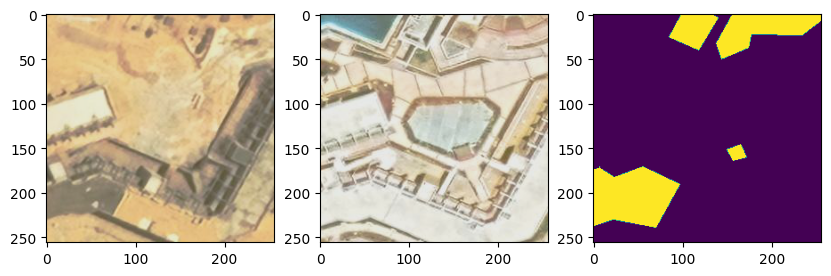

In [ ]:
# read a random sample - two set of images and the associated change mask
sample = np.random.randint(0,len(train_df))
# sample = 2005
print(sample)

fileA, fileB, fileL, _ = train_df.iloc[sample]

print(f' file A is {fileA}')
print(f' file B is {fileB}')
print(f' file Label is {fileL}')

im1 = Image.open(fileA)
im2 = Image.open(fileB)
lab = Image.open(fileL)

print(np.array(im1).shape)
print(np.array(im2).shape)
print(np.array(lab).shape)

fig,ax = plt.subplots(1,3,figsize=(10,10))

ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

In [ ]:
print(np.array(lab))

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
import matplotlib.pyplot as plt
def plot_image(image):
    b,g,r = cv2.split(image)
    mask_r = (r > 200).astype(np.uint8)
    mask_g = (g > 200).astype(np.uint8)
    mask_b = (b > 200).astype(np.uint8)

    # Count the number of pixels less than 100 in each channel
    count_r = np.sum(mask_r)
    count_g = np.sum(mask_g)
    count_b = np.sum(mask_b)
    # Calculate histograms for each channel
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
    print(count_r,count_g,count_b)
    # Plot histograms
    plt.figure(figsize=(10, 5))

    # Red channel histogram
    plt.subplot(1, 3, 1)
    plt.plot(hist_r, color='red')
    plt.title('Red Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    # Green channel histogram
    plt.subplot(1, 3, 2)
    plt.plot(hist_g, color='green')
    plt.title('Green Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    # Blue channel histogram
    plt.subplot(1, 3, 3)
    plt.plot(hist_b, color='blue')
    plt.title('Blue Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    # Show plot
    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess(img):
    b, g, r = cv2.split(img)

    # Apply the filter to each channel
    sharpened_b =  cv2.medianBlur(b, 5)
    sharpened_g =  cv2.medianBlur(g, 5)
    sharpened_r =  cv2.medianBlur(r, 5)
    sharpened_image = cv2.merge((sharpened_b, sharpened_g, sharpened_r))
    return sharpened_image

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tqdm import tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [ ]:
# Confusion Matrix
def confusion_matrix_sklearn(predictions, target):
    cm = confusion_matrix(target, predictions)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
class SVCModel:

  def __init__(self, save_model = False, get_best_params = False):

    self.param_grid = {
        'C':[1, 10, 100],
        'gamma':[1, 0.1, 0.001],
        'kernel':['linear','rbf']
    }

    self.grid_search = {}
    self.model = None
    self.save_model = save_model
    self.get_best_params = get_best_params


  def grid_seaarch(self, X_train, y_train):
    # we sample 10k of the dataset to grid search the SVC due to high computatuin time
    np.random.seed(0)
    random_indices = np.random.choice(X_train.shape[0], 10000, replace=False)

    X_train_sampled = X_train[random_indices]
    y_train_sampled = np.array(y_train)[random_indices]

    classifier = SVC(random_state=0)

    self.grid_search = GridSearchCV(estimator = classifier, param_grid = self.param_grid, cv = 5, scoring='accuracy')

    self.grid_search.fit(X_train_sampled, y_train_sampled)


  def fit(self, X_train, y_train):

    if self.get_best_params:
        self.grid_seaarch(X_train, y_train)

    if hasattr(self.grid_search, 'best_params_'):
        print('Best parameters are set: ', self.grid_search.best_params_)
        self.model = SVC(**self.grid_search.best_params_)
    else:
        print('Default parameters are set')
        self.model = SVC(random_state=0)

    self.model.fit(X_train, y_train)

    plot_learning_curve(self.model, "Learning Curve (SVC)", X_train, y_train, cv=5)

    if self.save_model:
      joblib.dump(self.model, '/content/drive/MyDrive/ML project/svc.pkl')

  def predict(self, X_test, y_test):
    y_pred = self.model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    F1= f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print("Accuracy Score :",accuracy*100)

    confusion_matrix_sklearn(y_pred, y_test)

    return accuracy, F1, recall, precision

In [ ]:
X = []
Y = []

for index, item in df.iterrows():

  im1 = item['file_path_A']
  im2 = item['file_path_B']
  label = item['file_path_label']

  image1 = preprocess(cv2.imread(im1))
  image2 = preprocess(cv2.imread(im2))

  label_target = 0
  mask_img = np.array(Image.open(label))
  if np.all(mask_img == 0):
      label_target = 1

  b1,g1,r1 = cv2.split(image1)

  b2,g2,r2 = cv2.split(image2)

  X.append(list(cv2.calcHist([b2], [0], None, [256], [0, 256]).flatten()))

  Y.append(label_target)

In [ ]:
Y[99]

0

In [ ]:
unique_classes = np.unique(Y)
print(unique_classes)

[0 1]


Default parameters are set


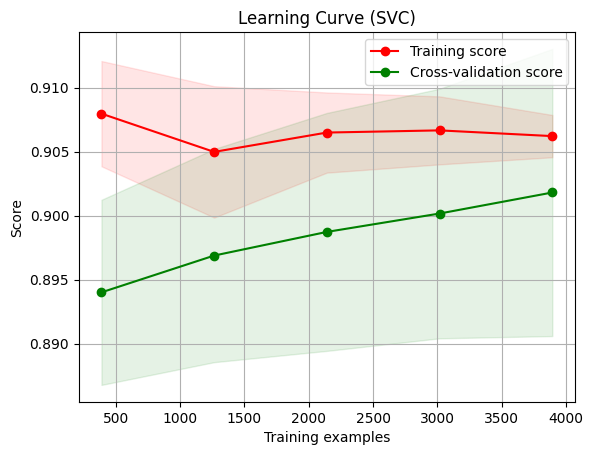

In [ ]:
model = SVCModel()
model.fit(X,Y)

In [ ]:
def adjust_brightness(img, target_brightness=210):
#     img = cv2.convertScaleAbs(img)

    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Split the channels
    h, s, v = cv2.split(hsv)
    # print(v)
    # Compute the average brightness of the image
    avg_brightness = v.mean()

    # Compute the difference in brightness
    brightness_diff = target_brightness - avg_brightness

    # Adjust the brightness of the image
    v_adjusted = cv2.add(v, brightness_diff)

    # Clip values to ensure they are within valid range [0, 255]
    v_adjusted = np.clip(v_adjusted, 0, 255)

    # Merge the channels back together
    adjusted_hsv = cv2.merge([h, s, v_adjusted])

    # Convert back to BGR color space
    adjusted_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)

    return adjusted_img

In [ ]:
Y_true = []
Y_pred = []

for index, item in df.iterrows():

  im1 = item['file_path_A']
  im2 = item['file_path_B']
  label = item['file_path_label']

  image1 = preprocess(cv2.imread(im1))
  image2 = preprocess(cv2.imread(im2))

  label_target = 0
  mask_img = np.array(Image.open(label))
  if np.all(mask_img == 0):
      label_target = 1

  Y_true.append(label_target)

  b1,g1,r1 = cv2.split(image1)

  b2,g2,r2 = cv2.split(image2)

  label_pred = 0

  threshold = 125

  sum1 = cv2.calcHist([b1], [0], None, [256], [0, 256]).flatten()[0:threshold].sum()

  sum2 = cv2.calcHist([b2], [0], None, [256], [0, 256]).flatten()[0:threshold].sum()

  if sum1 == 0 and sum2 == 0:
    label_pred = 1

  Y_pred.append(label_pred)

Accuracy Score : 34.67543138866064
F1 Score : 3.225806451612904
recall Score : 1.6398514851485149
precision Score : 98.14814814814815


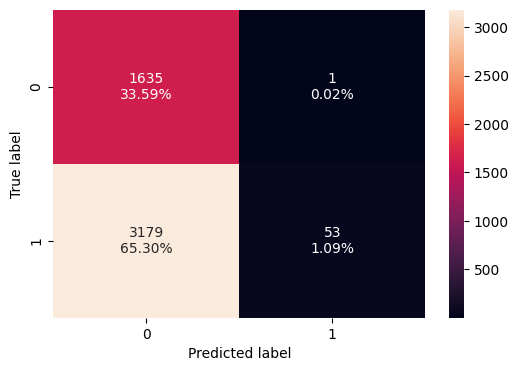

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_pred, Y_true)

Accuracy Score : 48.829087921117505
F1 Score : 37.52194632555806
recall Score : 23.143564356435643
precision Score : 99.0728476821192


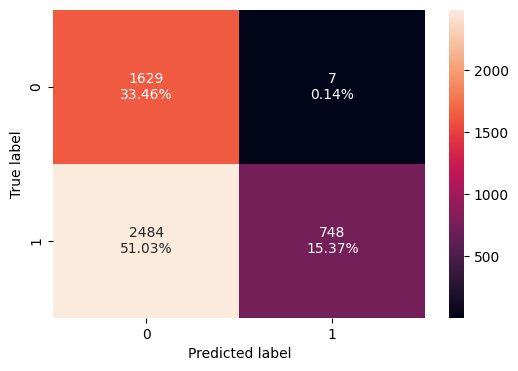

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_pred, Y_true)

Accuracy Score : 59.264585045193094
F1 Score : 56.040789181999564
recall Score : 39.10891089108911
precision Score : 98.82720875684127


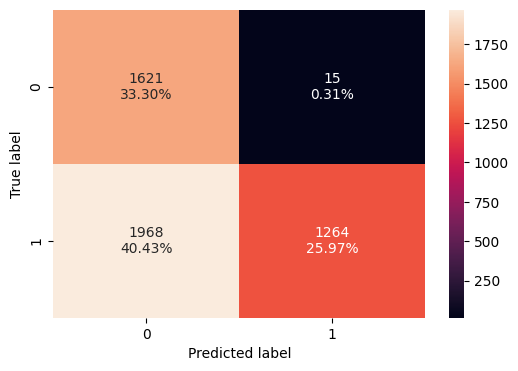

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_pred, Y_true)

Accuracy Score : 66.51602300739523
F1 Score : 79.83172482058897
recall Score : 99.81435643564357
precision Score : 66.51546391752578


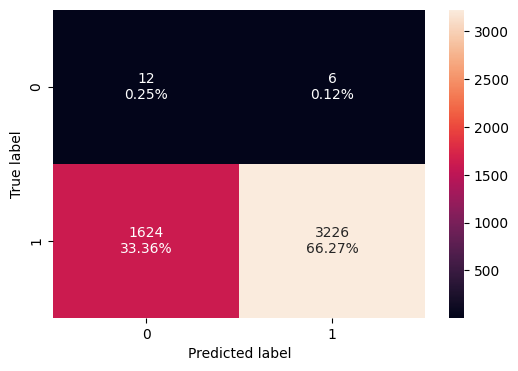

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 67.50205423171734
F1 Score : 80.27431421446384
recall Score : 99.59777227722772
precision Score : 67.23057644110276


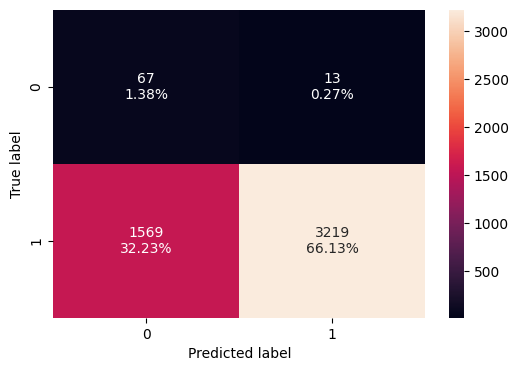

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 70.78882497945769
F1 Score : 81.82515337423312
recall Score : 99.04084158415841
precision Score : 69.7081881533101


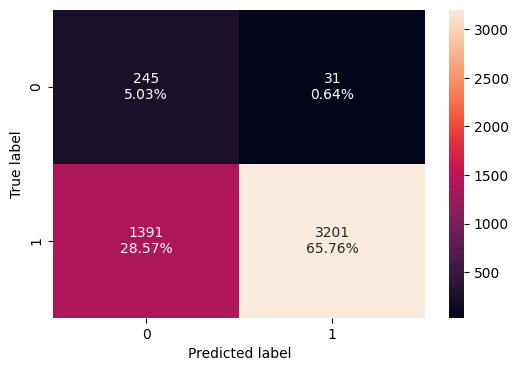

In [ ]:
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 78.24568611339359
F1 Score : 85.2691612185283
recall Score : 94.83292079207921
precision Score : 77.45766995198382


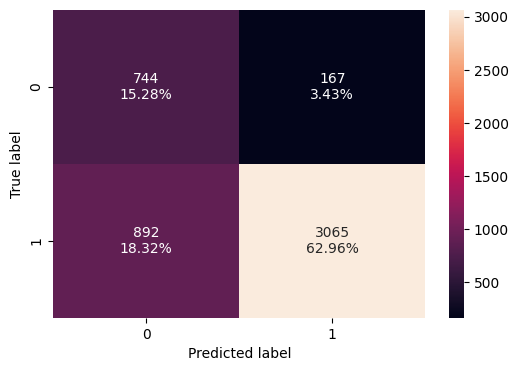

In [ ]:
# 25
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 80.34100246507806
F1 Score : 86.27563459056361
recall Score : 93.06930693069307
precision Score : 80.40630847367014


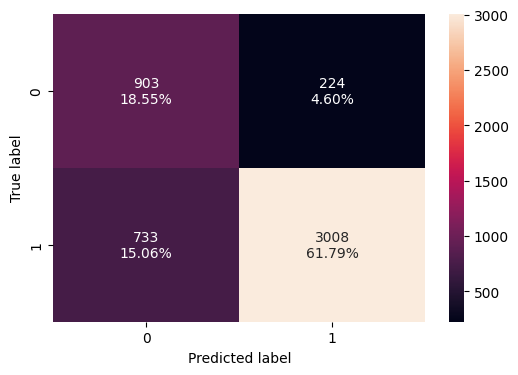

In [ ]:
# 30 blur
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 81.94330320460148
F1 Score : 86.62304063308477
recall Score : 88.0569306930693
precision Score : 85.23510032943994


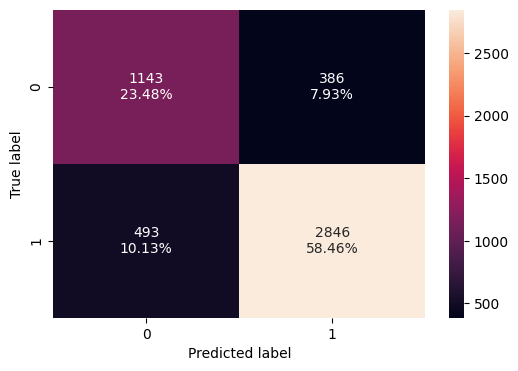

In [ ]:
# 30 original

accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)

Accuracy Score : 82.43631881676254
F1 Score : 86.71741494485009
recall Score : 86.35519801980197
precision Score : 87.0826833073323


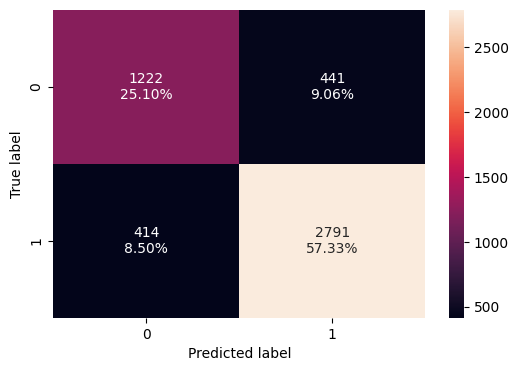

In [ ]:
# 50
accuracy = accuracy_score(Y_true, Y_pred)
F1= f1_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)

print("Accuracy Score :",accuracy*100)
print("F1 Score :",F1*100)
print("recall Score :",recall*100)
print("precision Score :",precision*100)

confusion_matrix_sklearn(Y_true, Y_pred)